In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

Pytorch default shape of images is of the order ```(channels, width, height)```

### **What is a classification problem?**
A classification problem involves predicting whether something is one thing or another.

Instead of trying to predict a straight line (predicting a number, also called a regression problem), we'll be working on a classification problem.

For example, you might want to:

**Binary classification**:
    
Target can be one of two options, e.g. yes or no.	Predict whether or not someone has heart disease based on their health parameters.

**Multi-class classification**:

Target can be one of more than two options.	Decide whether a photo of is of food, a person or a dog.

**Multi-label classification**:

Target can be assigned more than one label.	Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy).


Here, we're going to cover:

###**Topic - 	Contents**

```0. Architecture of a classification neural network```: Neural networks can come in almost any shape or size, but they typically follow a similar floor plan.

```1. Getting binary classification data ready```: Data can be almost anything but to get started we're going to create a simple binary classification dataset.

```2. Building a PyTorch classification model```: 	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop specific to classification.

```3. Fitting the model to data (training)```: We've got data and a model, now let's let the model (try to) find patterns in the (training) data.

```4. Making predictions and evaluating a model (inference)```:	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.

```5. Improving a model (from a model perspective)```:	We've trained an evaluated a model but it's not working, let's try a few things to improve it.

```6. Non-linearity```:	So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines?

```7. Replicating non-linear functions```:	We used non-linear functions to help model non-linear data, but what do these look like?

```8. Putting it all together with multi-class classification```:	Let's put everything we've done so far for binary classification together with a multi-class classification problem.

###**0. Architecture of a classification neural network**
Before we get into writing code, let's look at the general architecture of a classification neural network.

**Hyperparameter -	Binary Classification	- Multiclass classification**

```Input layer shape (in_features)```:	Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction).	Same as binary classification

```Hidden layer(s)```:	Problem specific, minimum = 1, maximum = unlimited.	Same as binary classification

```Neurons per hidden layer```:	Problem specific, generally 10 to 512.	Same as binary classification

```Output layer shape (out_features)```:	1 (one class or the other).	1 per class (e.g. 3 for food, person or dog photo)

```Hidden layer activation```:	Usually ReLU (rectified linear unit) but can be many others.Same as binary classification

```Output activation```:	Sigmoid (torch.sigmoid in PyTorch).	Softmax (torch.softmax in PyTorch)

```Loss function```:	Binary crossentropy (torch.nn.BCELoss in PyTorch).	Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)

```Optimizer```:	SGD (stochastic gradient descent), Adam (see torch.optim for more options).	Same as binary classification

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to gets hands-on with this setup throughout this notebook.



### **1. Make classification data and get it ready**
Let's begin by making some data.

We'll use the ```make_circles()``` method from Scikit-Learn to generate two circles with different coloured dots.(binary classification with 2 classes and 2 features)

In [ ]:
import sklearn
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=1000, noise=0.03, random_state=42)
X.shape, type(X), Y.shape, type(Y)

((1000, 2), numpy.ndarray, (1000,), numpy.ndarray)

In [ ]:
X[:5], Y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [ ]:
from collections import Counter
Counter(Y)

Counter({1: 500, 0: 500})

In [ ]:
#convert to dataframe for just good visualization purpose
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": Y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [ ]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

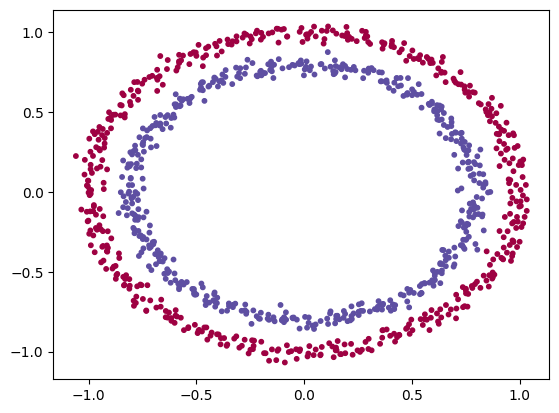

In [ ]:
#Plot our toy data
plt.scatter(X[:, 0], X[:, 1], c=Y, s=10, cmap=plt.cm.Spectral)
plt.show()

### **1.2 Turn data into tensors and create train and test splits**

In [ ]:
import torch

#converting to tensors
X_t = torch.from_numpy(X).type(torch.float)
Y_t = torch.from_numpy(Y).type(torch.float32)
X_t.shape, Y_t.shape, X_t[:5], Y_t[:5]

(torch.Size([1000, 2]),
 torch.Size([1000]),
 tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
#Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_t, Y_t, test_size=0.2, random_state=42)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

### **2. building the model**

We'll break it down into a few parts.

- Setting up device agnostic code (so our model can run on CPU or accelerator(i.e GPU) if it's available).
- Constructing a model by subclassing nn.Module.
- Defining a loss function and optimizer.
- Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and torch.nn as well as setting up device agnostic code.


In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'


Excellent, now device is setup, we can use it for any data or models we create and PyTorch will handle it on the CPU (default) or GPU if it's available.

**How about we create a model?**

We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as ouputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as ```supervised learning```. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:

1. Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2. Create 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a forward() method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [ ]:
class ClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features - hidden layer of 5 units
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y) - output layer of 1 unit

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_2(self.layer_1(x)) ## computation goes through layer_1 first then the output of layer_1 goes through layer_2

#instantiate the model
modelv0 = ClassificationModelV0()
modelv0.to(device) #move the model to device
modelv0

ClassificationModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**What's going on here?**

We've seen a few of these steps before.

The only major change is what's happening between ```self.layer_1``` and ```self.layer_2```.

```self.layer_1``` takes 2 input features ```in_features=2``` and produces 5 output features ```out_features=5```.

This is known as having 5 ```hidden units or neurons```.

This layer turns the input data from having 2 features to 5 features.

**Why do this?**

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

A visual example of what a similar classificiation neural network to the one we've just built looks like. Try create one of your own on the TensorFlow Playground website - https://playground.tensorflow.org/.

In [ ]:
next(modelv0.parameters()).device

device(type='cpu')

In [ ]:
list(modelv0.parameters()) #weight, bias of first layer, weight, bias of 2nd layer

[Parameter containing:
 tensor([[-0.3041, -0.0775],
         [-0.5293,  0.6441],
         [-0.5190,  0.3779],
         [ 0.2485,  0.2298],
         [-0.3823,  0.6427]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1554,  0.0910, -0.6231,  0.2968, -0.1061], requires_grad=True),
 Parameter containing:
 tensor([[-0.2049,  0.3841,  0.0997, -0.2474, -0.2264]], requires_grad=True),
 Parameter containing:
 tensor([-0.0214], requires_grad=True)]

In [ ]:
modelv0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427]])),
             ('layer_1.bias',
              tensor([ 0.1554,  0.0910, -0.6231,  0.2968, -0.1061])),
             ('layer_2.weight',
              tensor([[-0.2049,  0.3841,  0.0997, -0.2474, -0.2264]])),
             ('layer_2.bias', tensor([-0.0214]))])

**You can also do the same as above using ```nn.Sequential```**.

```nn.Sequential``` performs a forward pass computation of the input data through the layers in the order they appear.

Note: we could also do it in the ```__init__()``` of class subclassing ```nn.Module```
```class ClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.two_linear_layers(x)
```

In [ ]:
modelseqv0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
modelseqv0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing ```nn.Module```, why not just always use ```nn.Sequential```?

```nn.Sequential``` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd want something else to happen (rather than just straight-forward sequential computation like taking more kinds of input, changing the order of layers) you'll want to define your own custom nn.Module subclass.(just like functional model tf.Model(inputs, outputs) in tensorflow)

Now we've got a model, let's see what happens when we pass some data through it.

In [ ]:
modelseqv0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3948, -0.1807],
                      [-0.4035, -0.2421],
                      [-0.5283,  0.2522],
                      [ 0.5473, -0.6657],
                      [ 0.1642,  0.3653]])),
             ('0.bias', tensor([ 0.1282, -0.2518,  0.3691,  0.3716,  0.2644])),
             ('1.weight',
              tensor([[-0.0786, -0.1184,  0.0478, -0.0790, -0.1333]])),
             ('1.bias', tensor([0.2859]))])

In [ ]:
#lets make predictions with the initial model (here we are just using sequential model for now) to see how it predicts
with torch.inference_mode(): #make sure u infer with context manager
    y_test_preds_untrained = modelseqv0(X_test.to(device)) #makesure to send data to gpu device as model is on gpu device

print(f"Length of predictions: {len(y_test_preds_untrained)}, Shape: {y_test_preds_untrained.shape}") #observe shape has added dimension in axis=1
print(f"Length of test samples: {len(Y_test)}, Shape: {Y_test.shape}")
print(f"\n First 10 predictions:\n{torch.round(y_test_preds_untrained[:10])}")
print(f"\n First 10 test labels:\n{Y_test[:10]}")

#these are just random preds by the  untrained model
#see how our model are predicting all the examples as class 0. it means it will be correct 50% of the time

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

 First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### **2.1 Setup loss function and optimizer**
We've setup a ```loss``` (also called a ```criterion``` or ```cost function```) and optimizer before in notebook 01.

But different problem types require different loss functions.

For example, for a ```regression``` problem (predicting a number) you might used ```mean absolute error (MAE) torch.nn.L1Loss``` or  ```Mean squared error (MSE) or L2 Loss torch.nn.MSELoss```.

And for a ```binary classification``` problem (like ours), you'll often use ```binary cross entropy torch.nn.BCELossWithLogits or torch.nn.BCELoss``` as the loss function.

For a ```multi class classification``` , we ll use ```torch.nn.CrossEntropyLoss```

However, the same optimizer function can often be used across different problem spaces.

For example, the ```stochastic gradient descent optimizer (SGD, torch.optim.SGD())``` can be used for a range of problems, and the same applies to the ```Adam optimizer (torch.optim.Adam())```.


Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

Note: Recall a loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.

Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

**PyTorch has two binary cross entropy implementations:**

- ```torch.nn.BCELoss()``` - Creates a loss function that measures the binary cross entropy between the target (label) and predicted probabilities of the output layer.
- ```torch.nn.BCEWithLogitsLoss()``` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in. The output layer will be linear layer that gives logits and the sigmoid is applied to the logits in the loss to avoid numerical rounding errors, In the above case, sigmoid is applied already to the output layer. Sigmoid is used because this is binary classification and sigmoid outputs value between 0 and 1.

**Which one should you use?**

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use torch.optim.SGD() to optimize the model parameters with learning rate 0.1.

Note: There's a discussion on the PyTorch forums about the use of nn.BCELoss vs. nn.BCEWithLogitsLoss. It can be confusing at first but as with many things, it becomes easier with practice.

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = torch.nn.BCEWithLogitsLoss()

# Create an optimizer
myoptimizer = torch.optim.SGD(params=modelv0.parameters(), lr=0.1)

**Now let's also create an evaluation metric**

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

Of course, you could argue both of these are doing the same thing but evaluation metrics offer a different perspective.

After all, when evaluating your models it's good to look at things from multiple points of view.

There are several evaluation metrics that can be used for classification problems but let's start out with ```accuracy```.

```Accuracy``` can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

Let's write a function to do so.

In [ ]:
def accuracy_fn(y_preds, y_true):
    correct_preds = torch.eq(y_preds, y_true).sum().item() ## torch.eq() calculates where two tensors are equal
    acc = (correct_preds / len(y_true)) * 100
    return acc

Excellent! We can now use this function whilst training our model to measure it's performance alongside the loss.

### **3. Train model**
Okay, now we've got a loss function and optimizer ready to go, let's train a model.

Do you remember the steps in a PyTorch training loop?

### **3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)**

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [ ]:
with torch.inference_mode():
    y_logits = modelseqv0(X_test.to(device)) #forward pass thorugh untrained subclassed model
y_logits[:5] #random preds

tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853]])

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

```y = X Weights.T + bias```

The  outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data (X
in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

Let's try it out.

In [ ]:
preds_proba = torch.sigmoid(y_logits)
preds_proba[:10]

tensor([[0.5809],
        [0.5779],
        [0.5725],
        [0.5834],
        [0.5462],
        [0.5445],
        [0.5568],
        [0.5488],
        [0.5736],
        [0.5774]])

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function and argmax for softmax output in case of multiclass classification.

Note there is no need of rounding or argmax during training, we ll pass the predicted probs directly to the loss function, we can just use round/argmax for inference

In [ ]:
with torch.inference_mode():
    pred_labels = torch.round(torch.sigmoid(modelseqv0(X_test.to(device))))

pred_labels[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Note: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### **3.2 Building a training and testing loop**
Alright, we've discussed how to take our raw model outputs and convert them to prediction labels, now let's build a training loop.

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [ ]:
import numpy as np

epochs = 100
train_losses = []
eval_losses = []
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

torch.manual_seed(42)
for i in range(epochs):
    #forward pass
    modelv0.train()
    y_train_logits = modelv0(X_train).squeeze()
    loss = loss_fn(y_train_logits, Y_train) #squueze to remove the extra dimension (1, 200)
    acc = accuracy_fn(torch.round(torch.sigmoid(y_train_logits)), Y_train) #for accuracy function we need to send preds labels, hence sigmoid and round
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    #eval
    modelv0.eval()
    with torch.inference_mode():
        eval_logits = modelv0(X_test).squeeze()
        y_evals_preds = torch.round(torch.sigmoid(eval_logits)) #here as well we are converting to pred labels bcz this is inference
        eval_loss = loss_fn(eval_logits, Y_test)
        eval_acc = accuracy_fn(y_evals_preds, Y_test)
    if np.ceil(i % 10) == 0 or i == epochs-1:
        train_losses.append({"loss": loss,
                             "acc": acc})
        eval_losses.append({"loss": eval_loss,
                             "acc": eval_acc})
        print(f"Epoch: {i} | Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test loss: {eval_loss:.5f}, Test acc: {eval_acc:.2f}%")




Epoch: 0 | Loss: 0.69713, Train Accuracy: 46.75% | Test loss: 0.69687, Test acc: 43.50%
Epoch: 10 | Loss: 0.69504, Train Accuracy: 48.50% | Test loss: 0.69495, Test acc: 46.50%
Epoch: 20 | Loss: 0.69416, Train Accuracy: 49.38% | Test loss: 0.69412, Test acc: 44.50%
Epoch: 30 | Loss: 0.69375, Train Accuracy: 50.00% | Test loss: 0.69372, Test acc: 46.50%
Epoch: 40 | Loss: 0.69355, Train Accuracy: 50.38% | Test loss: 0.69353, Test acc: 47.00%
Epoch: 50 | Loss: 0.69343, Train Accuracy: 50.38% | Test loss: 0.69342, Test acc: 50.50%
Epoch: 60 | Loss: 0.69336, Train Accuracy: 49.75% | Test loss: 0.69337, Test acc: 50.50%
Epoch: 70 | Loss: 0.69330, Train Accuracy: 50.00% | Test loss: 0.69335, Test acc: 52.50%
Epoch: 80 | Loss: 0.69326, Train Accuracy: 49.50% | Test loss: 0.69335, Test acc: 55.00%
Epoch: 90 | Loss: 0.69323, Train Accuracy: 49.25% | Test loss: 0.69336, Test acc: 53.00%
Epoch: 99 | Loss: 0.69320, Train Accuracy: 50.12% | Test loss: 0.69338, Test acc: 53.50%


Hmm, what do you notice about the performance of our model?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 51% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

### **4. Make predictions and evaluate the model**
From the metrics it looks like our model is random guessing.

**How could we investigate this further?**

I've got an idea.

The data explorer's motto!

"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

```
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") #raw format link of the code from github
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
```

In [ ]:
#here we are writing the function instead of downloading from the repo - plotting decision boundary
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(X_train, Y_train, X_test, Y_test, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, Y_train, c="b", s=4, label="Train")
    plt.scatter(X_test, Y_test, c="g", s=4, label="Test")

    if predictions is not None:
        plt.scatter(X_test, predictions, c="r", s=4, label="Test Predictions")

    plt.legend(prop={"size":14})
    plt.show()

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    X, Y = X.to("cpu"), Y.to("cpu")
    model.to("cpu")

    #set up the meshgrid space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # h = max(x_max - x_min, y_max - y_min) / 200 #or set h=0.02 #somesmallval
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #we can also set using linspace
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    points = np.c_[xx.ravel(), yy.ravel()] #concatenate to create features as columns, just like stack along the last dimension
    # points = np.column_stack((xx.ravel(), yy.ravel())) #same
    #convert to torch tensor
    z = torch.from_numpy(points).float() #default numpy is float64. so we convert to float32 using float() for torch
    print(xx.shape, yy.shape, points.shape, z.shape)

    #Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(z)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(Y)) > 2:
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1) #multiclass
    else:
        y_preds = torch.round(torch.sigmoid(y_logits)) #binary

    #reshape preds and plot
    y_preds = y_preds.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_preds, cmap=plt.cm.Spectral, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])
(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])


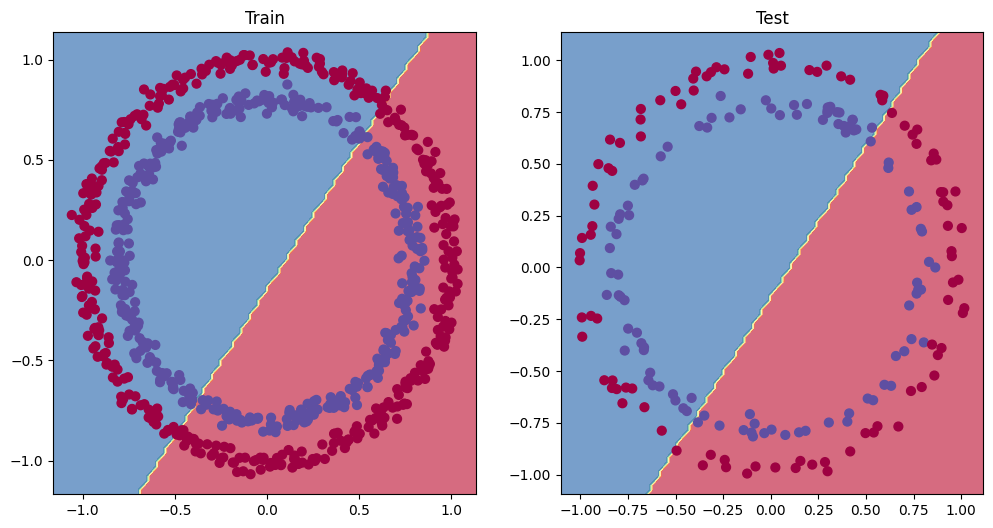

In [ ]:
#plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv0, X_test, Y_test)
plt.show()

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is ```underfitting```, meaning it's not learning predictive patterns from the data.

**How could we improve this?**

### **5. Improving a model (from a model perspective)**
Let's try to fix our model's underfitting problem.

Focusing specifically on the model (not the data), there are a few ways we could do this.

**Model improvement technique -	What does it do?**

```Add more layers```	Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network **deeper**.

```Add more hidden units```	Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network **wider**.

```Fitting for longer (more epochs)```	Your model might learn more if it had more opportunities to look at the data.

```Changing the activation functions```	Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).

```Change the learning rate```	Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.

```Change the loss function```	Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.

```Use transfer learning```	Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.

**Note**: *because you can adjust all of these by hand, they're referred to as hyperparameters.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [ ]:
modelv0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3267, -0.0792],
                      [-0.4915,  0.6463],
                      [-0.5143,  0.3777],
                      [ 0.2251,  0.2285],
                      [-0.4089,  0.6406]])),
             ('layer_1.bias',
              tensor([ 0.1440,  0.1114, -0.6192,  0.2839, -0.1192])),
             ('layer_2.weight',
              tensor([[-0.2303,  0.3406,  0.0141, -0.2050, -0.2695]])),
             ('layer_2.bias', tensor([0.0335]))])

In [ ]:
#lets add more hidden units and fit for longer(1000 epochs) and see if it improves the underfitting model
class ClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer3(self.layer2(self.layer1(x)))

modelv1 = ClassificationModelV1()
modelv1.to(device)
modelv1

ClassificationModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

Now we've got a model, we'll recreate a loss function and optimizer instance, using the same settings as before.

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
myoptimizer = torch.optim.SGD(params=modelv1.parameters(), lr=0.1)


Beautiful, model, optimizer and loss function ready, let's make a training loop.

This time we'll train for longer (epochs=1000 vs epochs=100) and see if it improves our model.

In [ ]:
import numpy as np

epochs = 1000
train_losses = []
eval_losses = []
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

torch.manual_seed(42)
for i in range(epochs):
    #forward pass
    modelv1.train()
    y_train_logits = modelv1(X_train).squeeze()
    loss = loss_fn(y_train_logits, Y_train) #squueze to remove the extra dimension (1, 200)
    acc = accuracy_fn(torch.round(torch.sigmoid(y_train_logits)), Y_train) #for accuracy function we need to send preds labels, hence sigmoid and round
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    #eval
    modelv1.eval()
    with torch.inference_mode():
        eval_logits = modelv1(X_test).squeeze()
        y_evals_preds = torch.round(torch.sigmoid(eval_logits)) #here as well we are converting to pred labels bcz this is inference
        eval_loss = loss_fn(eval_logits, Y_test)
        eval_acc = accuracy_fn(y_evals_preds, Y_test)
    if np.ceil(i % 100) == 0 or i == epochs-1:
        train_losses.append({"loss": loss,
                             "acc": acc})
        eval_losses.append({"loss": eval_loss,
                             "acc": eval_acc})
        print(f"Epoch: {i} | Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test loss: {eval_loss:.5f}, Test acc: {eval_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Train Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Train Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Train Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Train Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Train Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 999 | Loss: 0.69298, Train Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize.

(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])
(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])


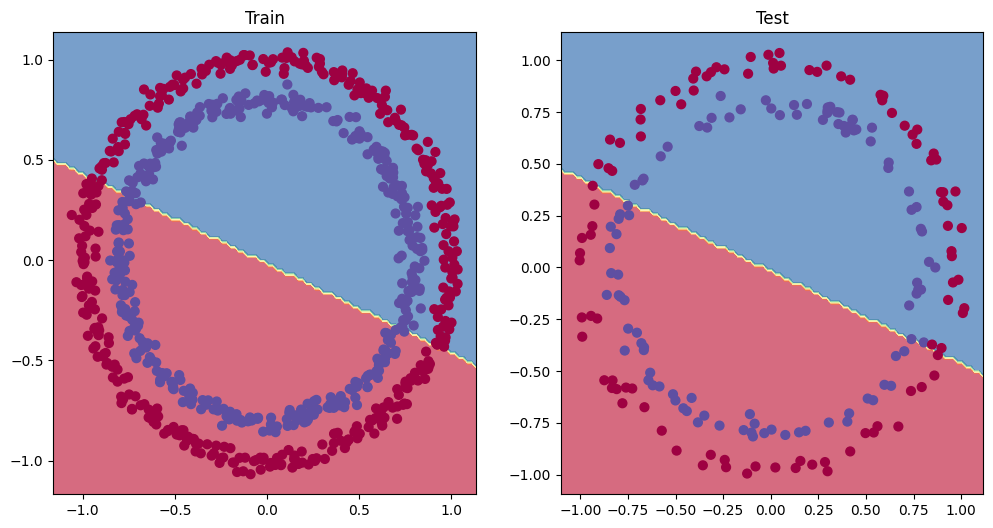

In [ ]:
#visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv1, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv1, X_test, Y_test)
plt.show()

Hmmm.

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data? Like we did in notebook 01?

### **5.1 Preparing data to see if our model can model a straight line**
Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

80 80 20 20


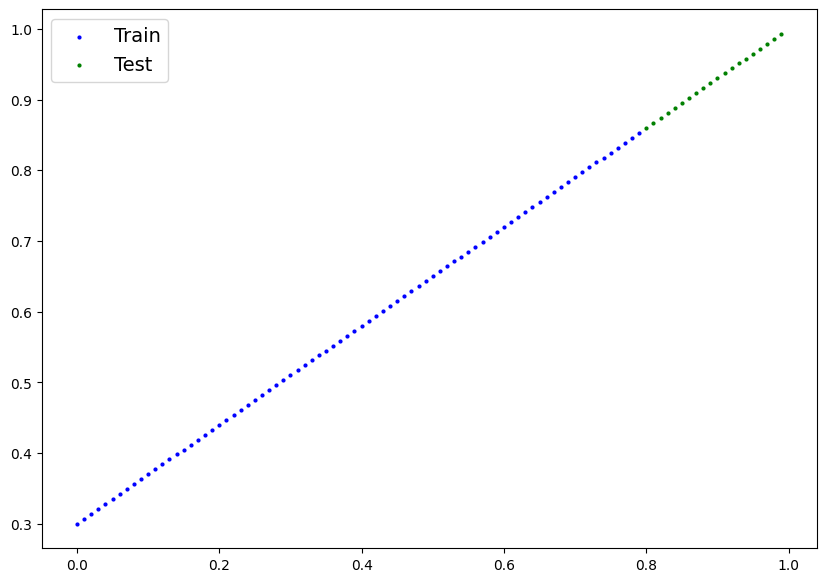

In [ ]:
## Create some data (same as notebook 01)
import numpy as np
weight = 0.7
bias = 0.3

## Create data
X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
Y_regression = weight * X_regression + bias

split = int(0.8 * len(X_regression))
X_train_reg, Y_train_reg = X_regression[:split], Y_regression[:split]
X_test_reg, Y_test_reg = X_regression[split:], Y_regression[split:]

# Check the lengths of each split
print(len(X_train_reg), len(Y_train_reg), len(X_test_reg), len(Y_test_reg))

#Lets also visualize
plot_predictions(X_train_reg, Y_train_reg, X_test_reg, Y_test_reg)

Note: while training, we need to modify the architecture to alogn with input shape and ouput shape with our new data and also the suitable loss function and optimizer to take newmodel params. This linear data has one input feature but our modelv1 has input with 2 input features. So lest change it and train the model.

For now, we can just use sequential model

In [ ]:
Y_train_reg.shape

torch.Size([80, 1])

In [ ]:
modelv1_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

modelv1_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#setup loss as L1Loss and also set the optimizer
loss_fn = torch.nn.L1Loss()
myoptimizer = torch.optim.SGD(params=modelv1_2.parameters(), lr=0.1)

In [ ]:
#lets train our modelv1 on this data
epochs = 1000
train_losses = []
eval_losses = []
X_train_reg, Y_train_reg = X_train_reg.to(device), Y_train_reg.to(device)
X_test_reg, Y_test_reg = X_test_reg.to(device), Y_test_reg.to(device)

torch.manual_seed(42)
for i in range(epochs):
    #forward pass
    modelv1_2.train()
    y_train_preds = modelv1_2(X_train_reg)
    loss = loss_fn(y_train_preds, Y_train_reg)
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    #eval
    modelv1_2.eval()
    with torch.inference_mode():
        eval_preds = modelv1_2(X_test_reg)
        eval_loss = loss_fn(eval_preds, Y_test_reg)
    if np.ceil(i % 100) == 0:
        train_losses.append({"loss": loss})
        eval_losses.append({"loss": eval_loss})
        print(f"Epoch: {i} | Loss: {loss:.5f} | Test loss: {eval_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603


Okay, unlike modelv1 on the classification data, it looks like modelv1_2's loss is actually going down.

Let's plot its predictions to see if that's so.

And remember, since our model and data are using the target device, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using .cpu() when we pass it to plot_predictions().

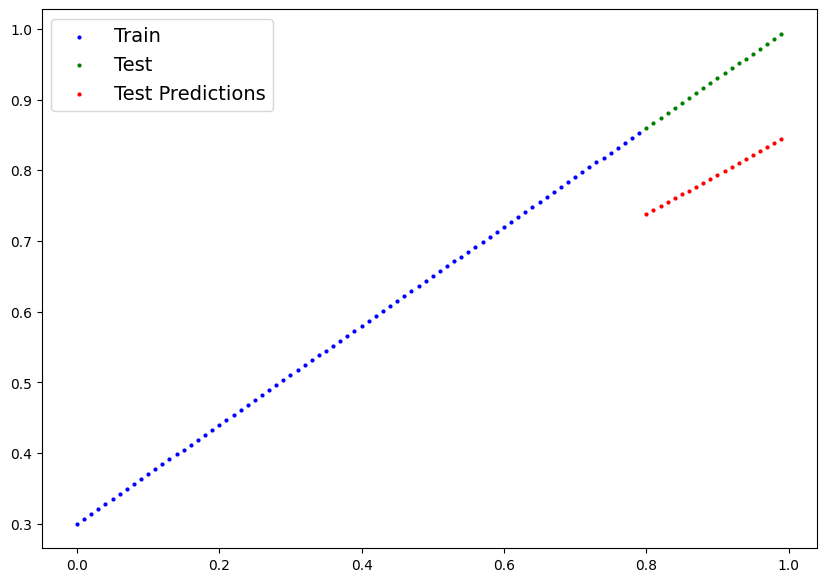

In [ ]:
# Turn on evaluation mode
modelv1_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = modelv1_2(X_test_reg)

plot_predictions(X_train_reg.cpu(), Y_train_reg.cpu(), X_test_reg.cpu(), Y_test_reg.cpu(), predictions=y_preds)

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

**Note**: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then **overfitting** (making the model perform too well) on that small example before increasing the amount data or the model size/design to **reduce overfitting**.

So what could it be?

Let's find out.

### **6. The missing piece: non-linearity**
We've seen our model can draw straight (linear) lines, thanks to its linear layers.

**But how about we give it the capacity to draw non-straight (non-linear) lines?**

How?

Let's find out.

###**6.1 Recreating non-linear data (red and blue circles)**
First, let's recreate the data to start off fresh. We'll use the same setup as before.

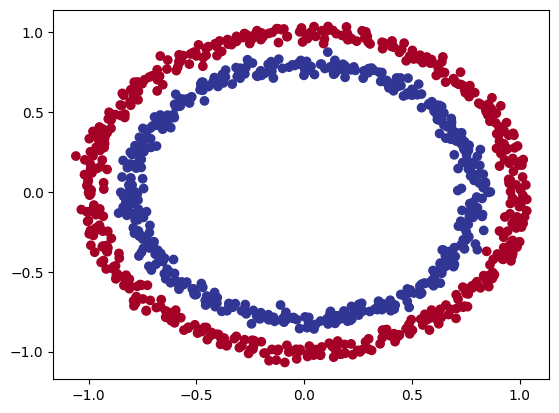

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

Nice! Now let's split it into training and test sets using 80% of the data for training and 20% for testing.

In [ ]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train[:5], Y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### **6.2 Building a model with non-linearity**
Now here comes the fun part.

**What kind of pattern do you think you could draw with unlimited straight (linear) and non-straight (non-linear) lines?**

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

**What do you think will happen when we introduce the capability for our model to use non-linear actviation functions?**

Well let's see.

PyTorch has a bunch of ready-made non-linear activation functions that do similiar but different things.

One of the most common and best performing is ```ReLU (rectified linear-unit, torch.nn.ReLU())```.

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [ ]:
# Build model with non-linear activation function
from torch import nn
class ClassificationModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

modelv2 = ClassificationModelV2().to(device)
modelv2

ClassificationModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

**Question: Where should I put the non-linear activation functions when constructing a neural network?**

A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantine, best to experiment, experiment, experiment.

Now we've got a model ready to go, let's create a binary classification loss function as well as an optimizer.

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss() #the last layer is still linear that return logits, so we shuld use this loss with logits
myoptimizer = torch.optim.SGD(modelv2.parameters(), lr=0.1)

Wonderful!

### **6.3 Training a model with non-linearity**
You know the drill, model, loss function, optimizer ready to go, let's create a training and testing loop.

In [ ]:
import numpy as np

epochs = 1000
train_losses = []
eval_losses = []
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
for i in range(epochs):
    #forward pass
    modelv2.train()
    y_train_logits = modelv2(X_train).squeeze()
    loss = loss_fn(y_train_logits, Y_train) #squueze to remove the extra dimension (1, 200)
    acc = accuracy_fn(torch.round(torch.sigmoid(y_train_logits)), Y_train) #for accuracy function we need to send preds labels, hence sigmoid and round
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    #eval
    modelv2.eval()
    with torch.inference_mode():
        eval_logits = modelv2(X_test).squeeze()
        y_evals_preds = torch.round(torch.sigmoid(eval_logits)) #here as well we are converting to pred labels bcz this is inference
        eval_loss = loss_fn(eval_logits, Y_test)
        eval_acc = accuracy_fn(y_evals_preds, Y_test)
    if np.ceil(i % 100) == 0 or i == epochs-1:
        train_losses.append({"loss": loss,
                             "acc": acc})
        eval_losses.append({"loss": eval_loss,
                             "acc": eval_acc})
        print(f"Epoch: {i} | Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test loss: {eval_loss:.5f}, Test acc: {eval_acc:.2f}%")



Epoch: 0 | Loss: 0.69295, Train Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Train Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Train Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Train Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Train Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Train Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Train Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Train Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Train Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Train Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 999 | Loss: 0.56890, Train Accuracy: 87.62% | Test loss: 0.57440, Test acc: 86.50%


Ho ho! That's looking far better!

### **6.4 Evaluating a model trained with non-linear activation functions**

Remember how our circle data is non-linear?

Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [ ]:
# Make predictions
modelv2.eval()
with torch.inference_mode():
    y_test_preds = torch.round(torch.sigmoid(modelv2(X_test))).squeeze()
y_test_preds[:10], Y_test[:10] # want preds in same format as truth labels during inference


(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])
(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])


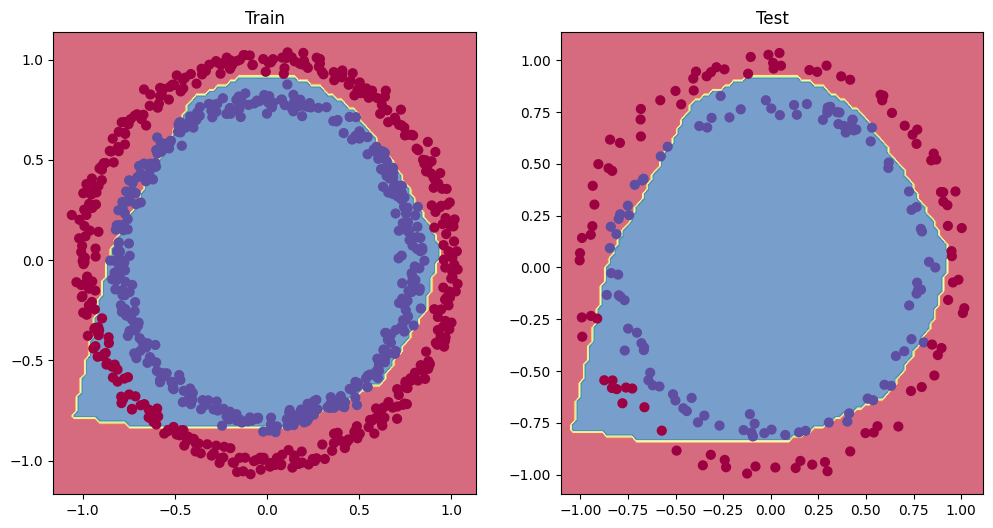

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv2, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv2, X_test, Y_test)

(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])
(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])


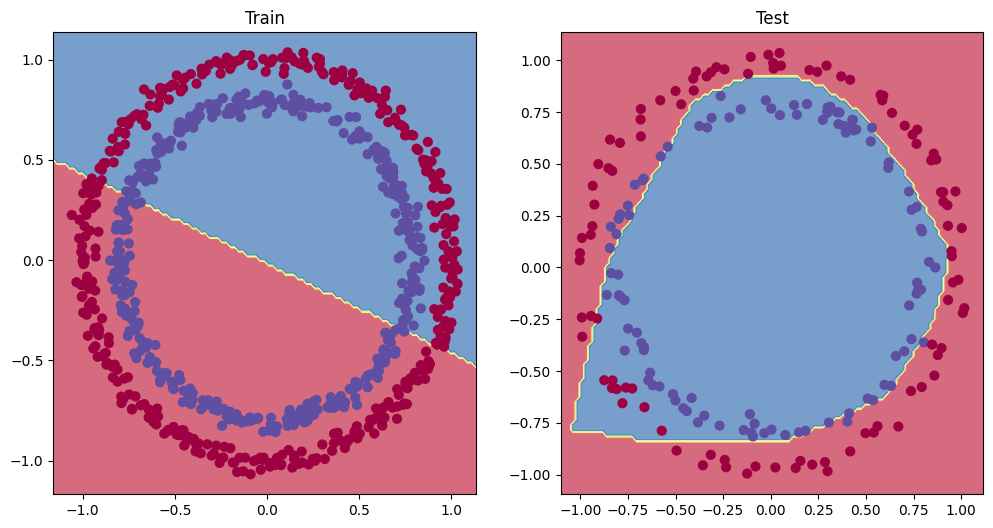

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv1, X_train, Y_train) ## modelv1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv2, X_test, Y_test) ## modelv2 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

### **7. Replicating non-linear activation functions**
We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

**Note**: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation look like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [ ]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

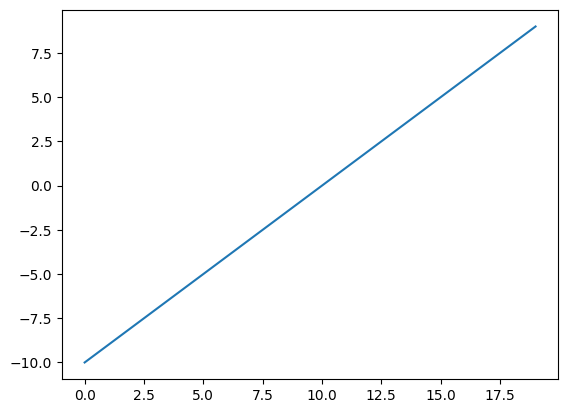

In [ ]:
plt.plot(A)

A straight line, nice.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [ ]:
## Create ReLU function by hand
def relu(A):
    return torch.maximum(torch.tensor(0), A)#makesure to convert to 0 to tensor, otherwise it throws error that first arg is not tensor

# Pass toy tensor through ReLU function
reluact = relu(A)
reluact

#see how relu converted all negative values to 0 and postive values to as it

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])


It looks like our ReLU function worked, all of the negative values are zeros.

Let's plot them.

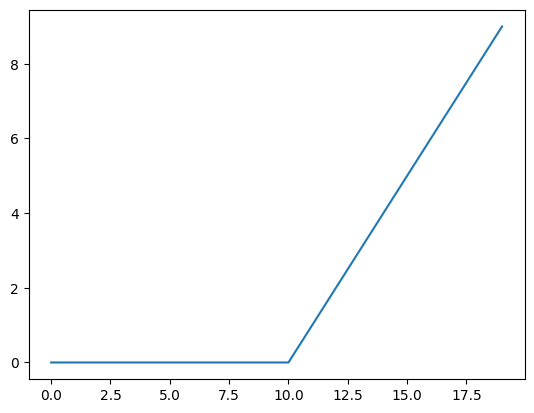

In [ ]:
plt.plot(reluact)

Nice! That looks exactly like the shape of the ReLU function on the Wikipedia page for ReLU).

How about we try the sigmoid function we've been using?

The sigmoid function formula goes like so:
1/ (1+e^-z)

In [ ]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigact = sigmoid(A)
sigact

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

Woah, those values look a lot like prediction probabilities we've seen earlier, let's see what they look like visualized.

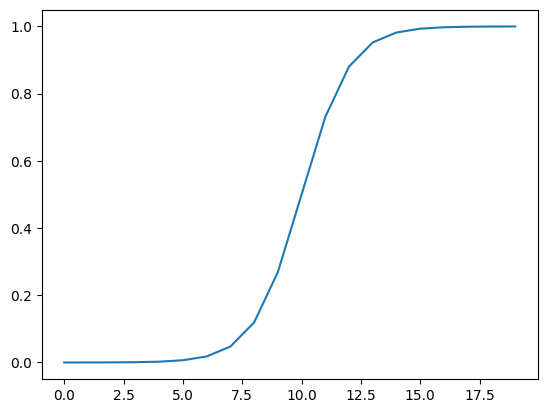

In [ ]:
plt.plot(sigact)

Looking good! We've gone from a straight line to a curved line.

Now there's plenty more non-linear activation functions that exist in PyTorch that we haven't tried.

But these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.


### **8. Putting things together by building a multi-class PyTorch model**
We've covered a fair bit.

But now let's put it all together using a multi-class classification problem.

Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

Example of binary vs. multi-class classification. Binary deals with two classes (one thing or another), where as multi-class classification can deal with any number of classes over two, for example, the popular ImageNet-1k dataset is used as a computer vision benchmark and has 1000 classes.

### **8.1 Creating mutli-class classification data**
To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's ```make_blobs()``` method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

- Create some multi-class data with make_blobs().
- Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
- Split the data into training and test sets using train_test_split().
- Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])
Shapes

torch.Size([1000, 2]) torch.Size([1000]) 4 [0 1 2 3]
torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])


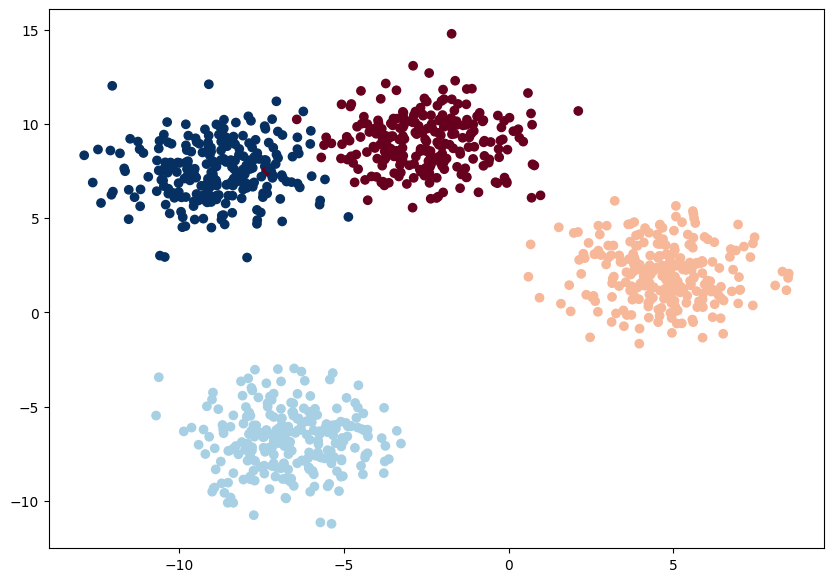

In [ ]:
from sklearn.datasets import make_blobs
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X, Y = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED) #creates data with 4 classes

#convert to tensors
X, Y = torch.from_numpy(X).type(torch.float32), torch.from_numpy(Y).type(torch.LongTensor) #LongTensor/Long gives int64 and for crossentropy loss, we need labels to be int representing class indices
print(X[:5], Y[:5])

#split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

print("Shapes\n")
print(X.shape, Y.shape, len(np.unique(Y)), np.unique(Y))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

#visualization
# 4. Plot data with 2 features
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdBu)

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

**Question: Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?**



###**8.2 Building a multi-class classification model in PyTorch**
We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to model_3 but this still capable of handling multi-class data?

To do so, let's create a subclass of nn.Module that takes in three hyperparameters:

- ```input_features``` - the number of X features coming into the model.
- ```output_features``` - the ideal numbers of output features we'd like (this will be equivalent to ```NUM_CLASSES``` or the number of classes in your multi-class classification problem).
- ```hidden_units``` - the number of hidden neurons we'd like each hidden layer to use.

Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder).

Then we'll create the model class using the hyperparameters above.

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [ ]:
from torch import nn

# Build multiclassclassification model
class MultiClassClassificationV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8): #we can inputs to the model by specifying in the constructor
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            output_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
modelv4 = MultiClassClassificationV0(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
modelv4

MultiClassClassificationV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

Excellent! Our multi-class model is ready to go, let's create a loss function and optimizer for it.

### **8.3 Creating a loss function and optimizer for a multi-class PyTorch model**
Since we're working on a multi-class classification problem, we'll use the ```nn.CrossEntropyLoss()``` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our modelv4 parameters

In [ ]:
## Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
myoptimizer = torch.optim.SGD(params=modelv4.parameters(), lr=0.1) ## exercise: try changing the learning rate here and seeing what happens to the model's performance

###**8.4 Getting prediction probabilities for a multi-class PyTorch model**

Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
modelv4.eval()
with torch.inference_mode():
    y_preds_logits = modelv4(X.to(device))

y_preds_logits[:5]

tensor([[-0.2651, -0.1140,  0.4499, -0.4943],
        [-0.2829,  0.1523,  0.1424, -0.8385],
        [-0.3125,  0.1665,  0.1402, -0.8788],
        [ 0.2598,  0.3814, -0.2176, -0.3364],
        [ 0.1958,  0.4072, -0.2516, -0.4208]])


**What's coming out here?**

It looks like we get one value per feature of each sample.

Let's check the shape to confirm.

In [ ]:
## How many elements in a single prediction sample?
y_preds_logits.shape, y_preds_logits[0].shape, NUM_CLASSES

(torch.Size([1000, 4]), torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

**Do you remember what the raw outputs of our model are called?**

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed ```logits```, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the ```softmax activation``` function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [ ]:
y_preds_probs = torch.softmax(y_preds_logits, dim=1)
y_preds_probs[:5], y_preds_logits[:5], y_preds_probs.shape

(tensor([[0.1999, 0.2325, 0.4086, 0.1590],
         [0.2151, 0.3324, 0.3291, 0.1234],
         [0.2103, 0.3396, 0.3307, 0.1194],
         [0.3030, 0.3421, 0.1880, 0.1669],
         [0.2929, 0.3618, 0.1872, 0.1581]]),
 tensor([[-0.2651, -0.1140,  0.4499, -0.4943],
         [-0.2829,  0.1523,  0.1424, -0.8385],
         [-0.3125,  0.1665,  0.1402, -0.8788],
         [ 0.2598,  0.3814, -0.2176, -0.3364],
         [ 0.1958,  0.4072, -0.2516, -0.4208]]),
 torch.Size([1000, 4]))

Hmm, what's happened here?

It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

Let's check.

In [ ]:
torch.sum(y_preds_probs, dim=1)[:5] #see how each example probs are summing up to 1

tensor([1., 1., 1., 1., 1.])

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using ```torch.argmax()```.

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_preds_probs[0]) #first sample
print(torch.argmax(y_preds_probs[0]))

tensor([0.1999, 0.2325, 0.4086, 0.1590])
tensor(2)


You can see the output of torch.argmax() returns 2, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 2.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

In [ ]:
#argmax to get the class label - note we do this for inference. for loss wie either send logits or pred probabilities
y_preds_labels = torch.argmax(y_preds_probs, dim=1)
y_preds_logits[:5], y_preds_probs[:5], y_preds_labels[:5]

(tensor([[-0.2651, -0.1140,  0.4499, -0.4943],
         [-0.2829,  0.1523,  0.1424, -0.8385],
         [-0.3125,  0.1665,  0.1402, -0.8788],
         [ 0.2598,  0.3814, -0.2176, -0.3364],
         [ 0.1958,  0.4072, -0.2516, -0.4208]]),
 tensor([[0.1999, 0.2325, 0.4086, 0.1590],
         [0.2151, 0.3324, 0.3291, 0.1234],
         [0.2103, 0.3396, 0.3307, 0.1194],
         [0.3030, 0.3421, 0.1880, 0.1669],
         [0.2929, 0.3618, 0.1872, 0.1581]]),
 tensor([2, 1, 1, 1, 1]))

###**8.5 Creating a training and testing loop for a multi-class PyTorch model**

Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [ ]:
epochs = 100
train_losses = []
test_losses = []
torch.manual_seed(42)
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for i in range(epochs):
    modelv4.train()
    y_preds_logits = modelv4(X_train)
    y_preds_probs = torch.softmax(y_preds_logits, dim=1)
    y_preds_labels = torch.argmax(y_preds_probs, dim=1).squeeze()
    loss = loss_fn(y_preds_logits, Y_train)
    acc = accuracy_fn(y_preds_labels, Y_train)
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    modelv4.eval()
    with torch.inference_mode():
        y_eval_logits = modelv4(X_test)
        y_eval_preds = y_eval_logits.argmax(dim=1).squeeze() #see we can also perform argmax directly on  logits instrad of converting to softmax before argmax
        eval_loss = loss_fn(y_eval_logits, Y_test)
        eval_acc = accuracy_fn(y_eval_preds, Y_test)

    if np.ceil(i % 10 == 0) or i==epochs-1:
        print(f"Epoch: {i} | Training Loss: {loss:.4f} | Training Accuracy: {acc:.2f}% | Test Loss: {eval_loss:.5f}, Test Accuracy: {eval_acc:.2f}%")

Epoch: 0 | Training Loss: 1.1588 | Training Accuracy: 40.38% | Test Loss: 1.07554, Test Accuracy: 48.00%
Epoch: 10 | Training Loss: 0.6448 | Training Accuracy: 96.75% | Test Loss: 0.66069, Test Accuracy: 97.50%
Epoch: 20 | Training Loss: 0.4254 | Training Accuracy: 98.50% | Test Loss: 0.43074, Test Accuracy: 100.00%
Epoch: 30 | Training Loss: 0.2529 | Training Accuracy: 99.12% | Test Loss: 0.24508, Test Accuracy: 99.50%
Epoch: 40 | Training Loss: 0.1123 | Training Accuracy: 99.25% | Test Loss: 0.10229, Test Accuracy: 99.50%
Epoch: 50 | Training Loss: 0.0663 | Training Accuracy: 99.25% | Test Loss: 0.05848, Test Accuracy: 99.50%
Epoch: 60 | Training Loss: 0.0507 | Training Accuracy: 99.25% | Test Loss: 0.04293, Test Accuracy: 99.50%
Epoch: 70 | Training Loss: 0.0430 | Training Accuracy: 99.25% | Test Loss: 0.03491, Test Accuracy: 99.50%
Epoch: 80 | Training Loss: 0.0384 | Training Accuracy: 99.25% | Test Loss: 0.02988, Test Accuracy: 99.50%
Epoch: 90 | Training Loss: 0.0352 | Training A

###**8.6 Making and evaluating predictions with a PyTorch multi-class model**
It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [ ]:
# Make predictions
modelv4.eval()
with torch.inference_mode():
    y_test_logits = modelv4(X_test)

# View the first 10 predictions i.e logits
y_test_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (Y_test) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using ```torch.softmax()```) then to prediction labels (by taking the ```argmax()``` of each sample).

**Note**: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, ```y_preds = torch.argmax(y_logits, dim=1)```, this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [ ]:
# Turn predicted logits in prediction probabilities
y_preds_probs = torch.softmax(y_test_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_preds_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]} \nLabels: {Y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_preds, Y_test)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


Nice! Our model predictions are now in the same form as our test labels.

Let's visualize them with ```plot_decision_boundary()```, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (plot_decision_boundary() does this automatically for us).

(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])
(101, 101) (101, 101) (10201, 2) torch.Size([10201, 2])


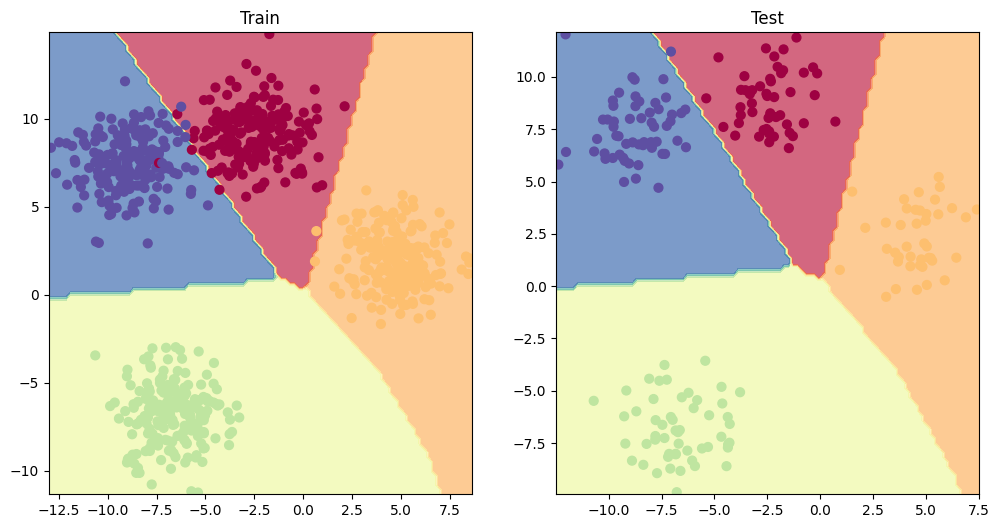

In [ ]:
#note plot_decision_boundary only considers first 2 features in the code to plot and just remember we have 4 features in the data. for now we are just plotting with 2 features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv4, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv4, X_test, Y_test)

**Note**: see even if we remove non-linearity i.e relu from our model, it still can give the good decision boundary. Bcuz the data is linearly spearable and neural network is capable of doing it

Epoch: 0 | Training Loss: 1.0432 | Training Accuracy: 65.50% | Test Loss: 0.57861, Test Accuracy: 95.50%
Epoch: 10 | Training Loss: 0.1440 | Training Accuracy: 99.12% | Test Loss: 0.13037, Test Accuracy: 99.00%
Epoch: 20 | Training Loss: 0.0806 | Training Accuracy: 99.12% | Test Loss: 0.07216, Test Accuracy: 99.50%
Epoch: 30 | Training Loss: 0.0592 | Training Accuracy: 99.12% | Test Loss: 0.05133, Test Accuracy: 99.50%
Epoch: 40 | Training Loss: 0.0489 | Training Accuracy: 99.00% | Test Loss: 0.04098, Test Accuracy: 99.50%
Epoch: 50 | Training Loss: 0.0429 | Training Accuracy: 99.00% | Test Loss: 0.03486, Test Accuracy: 99.50%
Epoch: 60 | Training Loss: 0.0391 | Training Accuracy: 99.00% | Test Loss: 0.03083, Test Accuracy: 99.50%
Epoch: 70 | Training Loss: 0.0364 | Training Accuracy: 99.00% | Test Loss: 0.02799, Test Accuracy: 99.50%
Epoch: 80 | Training Loss: 0.0345 | Training Accuracy: 99.00% | Test Loss: 0.02587, Test Accuracy: 99.50%
Epoch: 90 | Training Loss: 0.0330 | Training Ac

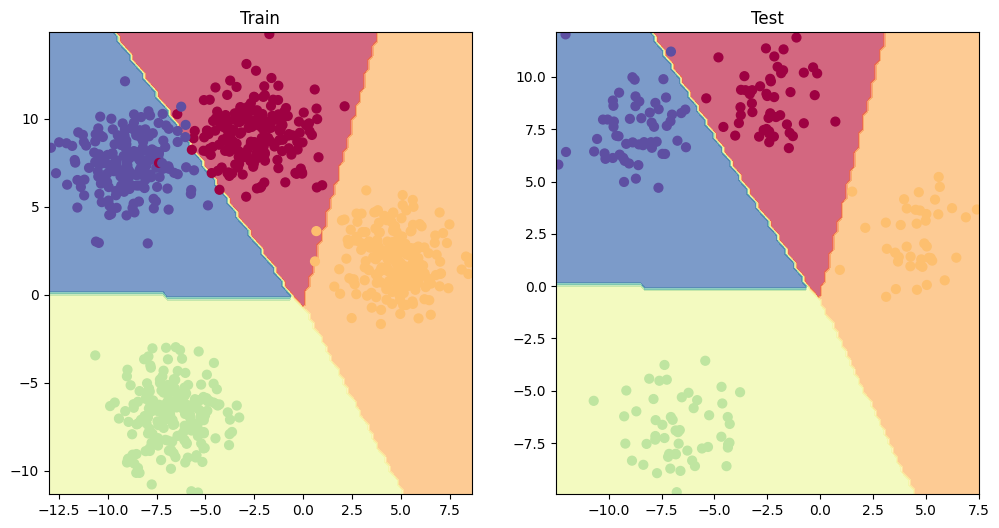

In [ ]:
from torch import nn

# Build multiclassclassification model with no non linearity for lienarly spearable data
class MultiClassClassificationV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
modelv5 = MultiClassClassificationV1(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
myoptimizer = torch.optim.SGD(params=modelv5.parameters(), lr=0.1)

epochs = 100
train_losses = []
test_losses = []
torch.manual_seed(42)
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for i in range(epochs):
    modelv5.train()
    y_preds_logits = modelv5(X_train)
    y_preds_probs = torch.softmax(y_preds_logits, dim=1)
    y_preds_labels = torch.argmax(y_preds_probs, dim=1).squeeze()
    loss = loss_fn(y_preds_logits, Y_train)
    acc = accuracy_fn(y_preds_labels, Y_train)
    myoptimizer.zero_grad()
    loss.backward()
    myoptimizer.step()

    modelv5.eval()
    with torch.inference_mode():
        y_eval_logits = modelv5(X_test)
        y_eval_preds = y_eval_logits.argmax(dim=1).squeeze()
        eval_loss = loss_fn(y_eval_logits, Y_test)
        eval_acc = accuracy_fn(y_eval_preds, Y_test)

    if np.ceil(i % 10 == 0) or i==epochs-1:
        print(f"Epoch: {i} | Training Loss: {loss:.4f} | Training Accuracy: {acc:.2f}% | Test Loss: {eval_loss:.5f}, Test Accuracy: {eval_acc:.2f}%")

modelv5.eval()
with torch.inference_mode():
    y_test_logits = modelv5(X_test)

y_preds_probs = torch.softmax(y_test_logits, dim=1)
y_preds = y_preds_probs.argmax(dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv5, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv5, X_test, Y_test)

#see neural network able to spearate the data even without nonlinearity function. Earlier it couldnt bcuz the circle data is not linearly separable

### **9. More classification evaluation metrics**
So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

**Metric name/Evaluation method  - 	Defintion -	Code**
- ```Accuracy```: tp/ tp + fp + fn + tn	Out of 100 predictions, how many does your model get correct?
    E.g. 95% accuracy means it gets 95/100 predictions correct.
    ```torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()```

- ```Precision```:	tp/ tp + fp : Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).	```torchmetrics.Precision() or sklearn.metrics.precision_score()```

- ```Recall```:	tp/ tp + fn: Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.	```torchmetrics.Recall() or sklearn.metrics.recall_score()```

- ```F1-score```: 2pr / p + r:	Combines precision and recall into one metric. 1 is best, 0 is worst.	```torchmetrics.F1Score() or sklearn.metrics.f1_score()```

- ```Confusion matrix```:	Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).	```torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()```

- ```Classification report```:	Collection of some of the main classification metrics such as precision, recall and f1-score.	```sklearn.metrics.classification_report()```

- ```roc auc curve```

```Scikit-Learn``` (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out ```TorchMetrics```,https://torchmetrics.readthedocs.io/en/latest/ especially the ```TorchMetrics classification section``` https://torchmetrics.readthedocs.io/en/stable/pages/classification.html.

Let's try the ```torchmetrics.Accuracy``` metric out.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
#task argument to either 'binary', 'multiclass' or multilabel
#acc = torchmetrics.functional.accuracy(preds, target, task="multiclass", num_classes=5) #functional, above is class based which internally call this functional
#accuracy = Accuracy(task="multiclass", num_classes=3, top_k=2) #top_k kwarg

#cal accuracy
torchmetrics_accuracy(y_preds, Y_test)

tensor(0.9950)

### **Exercises**
All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using device-agonistic code.

Resources:

- Exercise template notebook for 02 https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb

- Example solutions notebook for 02 (try the exercises before looking at this) https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/02_pytorch_classification_exercise_solutions.ipynb

    - Make a binary classification dataset with Scikit-Learn's make_moons() function.
    - For consistency, the dataset should have 1000 samples and a random_state=42.
    - Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.
- Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
    - Feel free to use any combination of PyTorch layers (linear and non-linear) you want.
- Setup a binary classification compatible loss function and optimizer to use when training the model.
- Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
    - To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
    - Train the model for long enough for it to reach over 96% accuracy.
    - The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
- Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.
- Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the ML cheatsheet website for the formula.
- Create a multi-class dataset using the spirals data creation function from CS231n https://cs231n.github.io/neural-networks-case-study/(see below for the code).
    - Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
    - Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
    - Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
    - Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

** Code for creating a spiral dataset from CS231n**'
```
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
```


Using device: cpu
Shapes: torch.Size([800, 2]), torch.Size([800]), torch.Size([200, 2]), torch.Size([200])
BinaryClassificationV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
Epoch: 0 | Training Loss: 0.6953 | Training Accuracy: 37.38% | Test Loss: 0.69446, Test Accuracy: 49.50%
Epoch: 100 | Training Loss: 0.3886 | Training Accuracy: 81.62% | Test Loss: 0.40304, Test Accuracy: 76.00%
Epoch: 200 | Training Loss: 0.2429 | Training Accuracy: 88.50% | Test Loss: 0.24102, Test Accuracy: 89.50%
Epoch: 300 | Training Loss: 0.2011 | Training Accuracy: 90.88% | Test Loss: 0.19153, Test Accuracy: 93.50%
Epoch: 400 | Training Loss: 0.1658 | Training Accuracy: 92.88% | Test Loss: 0.15421, Test Accuracy: 94.00%
Epoch: 500 | Training Loss: 0.1236 | Training Accuracy: 95.12% | Test Loss: 0.11175,

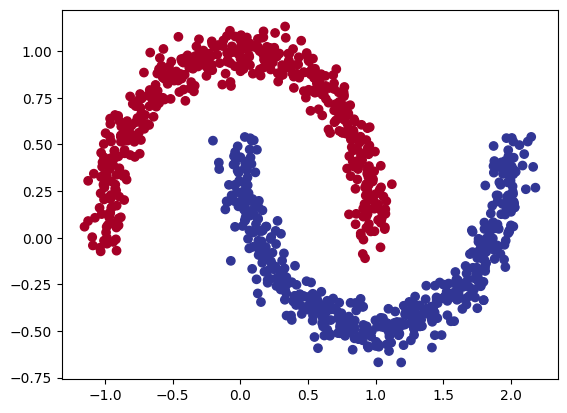

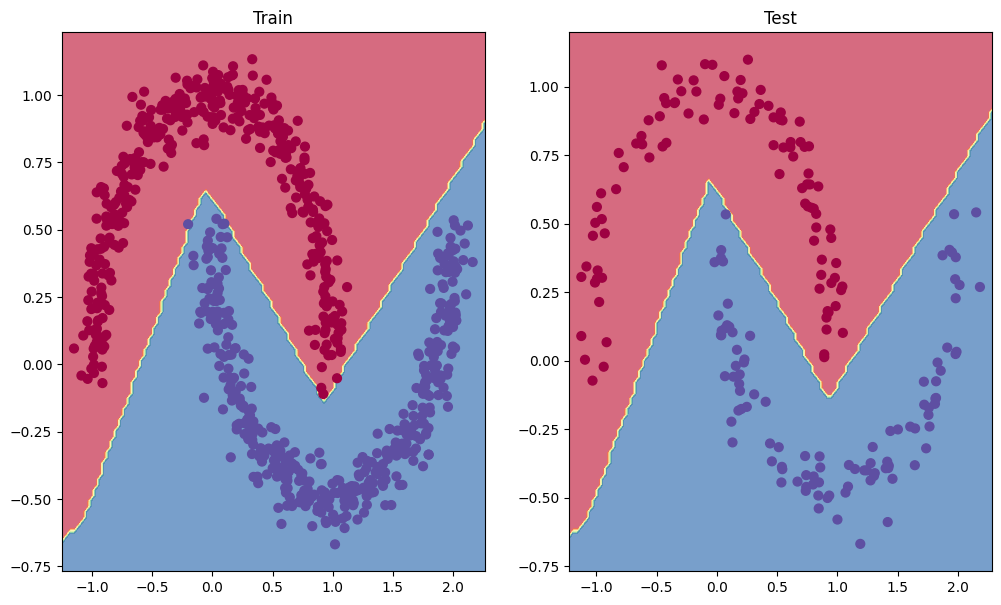

In [ ]:
#Binary Classification make_moons
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

#Hyperparameters
RANDOM_SEED = 42
NUM_SAMPLES = 1000
torch.manual_seed(RANDOM_SEED)
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#create dataset
X, Y = make_moons(n_samples=NUM_SAMPLES, noise=0.07, random_state=RANDOM_SEED)
X, Y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(Y).type(torch.float).to(device)

#plot
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)
#Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)
print(f"Shapes: {X_train.shape}, {Y_train.shape}, {X_test.shape}, {Y_test.shape}")

def accuracy_fn(y_preds, y_true):
    preds = torch.eq(y_preds, y_true).sum().item()
    acc = (preds / len(y_true)) * 100
    return acc

class BinaryClassificationV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

modelv6 = BinaryClassificationV0(in_features=2, out_features=1, hidden_units=10).to(device)
print(modelv6)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=modelv6.parameters(), lr=0.1)
epochs = 1000
train_losses = []
test_losses = []
for i in range(epochs):
    modelv6.train()
    y_pred_logits = modelv6(X_train)
    y_pred_probs = torch.sigmoid(y_pred_logits)
    y_preds = torch.round(y_pred_probs).squeeze()
    loss = loss_fn(y_pred_logits.squeeze(), Y_train)
    acc = accuracy_fn(y_preds, Y_train)
    # print(acc)
    # print(y_preds.shape)
    # print(Y_train.shape)
    # print(y_preds.dtype, Y_train.dtype)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    modelv6.eval()
    with torch.inference_mode():
        y_eval_logits = modelv6(X_test)
        y_eval_probs = torch.sigmoid(y_eval_logits)
        y_eval_preds = torch.round(y_eval_probs).squeeze()
        eval_loss = loss_fn(y_eval_logits.squeeze(), Y_test)
        eval_acc = accuracy_fn(y_eval_preds, Y_test)

    if np.ceil(i % 100) == 0 or i==epochs-1:
        print(f"Epoch: {i} | Training Loss: {loss:.4f} | Training Accuracy: {acc:.2f}% | Test Loss: {eval_loss:.5f}, Test Accuracy: {eval_acc:.2f}%")

#inference
modelv6.eval()
with torch.inference_mode():
    y_test_logits = modelv6(X_test)
    y_test_probs = torch.sigmoid(y_test_logits)
    y_test_preds = torch.round(y_test_probs).squeeze()
    test_loss = loss_fn(y_test_logits.squeeze(), Y_test)
    test_acc = accuracy_fn(y_test_preds, Y_test)

#plot
def plot_decision_boundary(model, X, Y):
    X, Y = X.to("cpu"), Y.to("cpu")
    model = model.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

    model.eval()
    with torch.inference_mode():
        y_pred_logits = model(points)

    if len(torch.unique(Y)) > 2:
        y_preds = torch.softmax(y_pred_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_preds = torch.round(torch.sigmoid(y_pred_logits)) # binary

    print(xx.shape, yy.shape, y_preds.shape)
    y_preds = y_preds.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_preds, cmap=plt.cm.Spectral, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv6, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv6, X_test, Y_test)
plt.show()


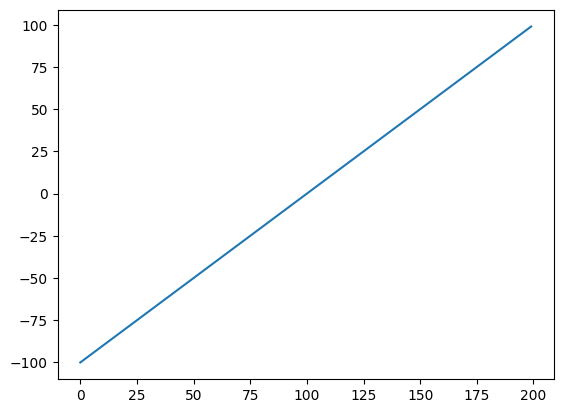

In [ ]:
#Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch

tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

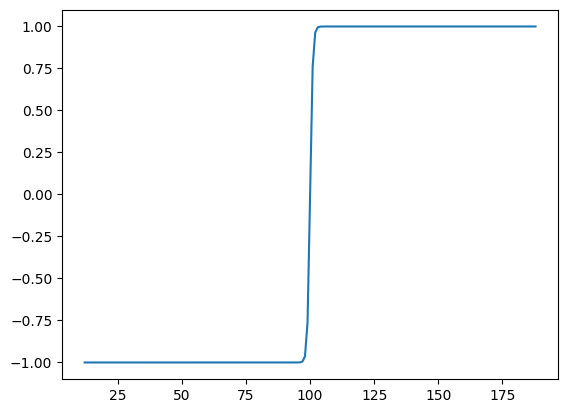

In [ ]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

mytanh_tensor = tanh(tensor_A)
plt.plot(mytanh_tensor)

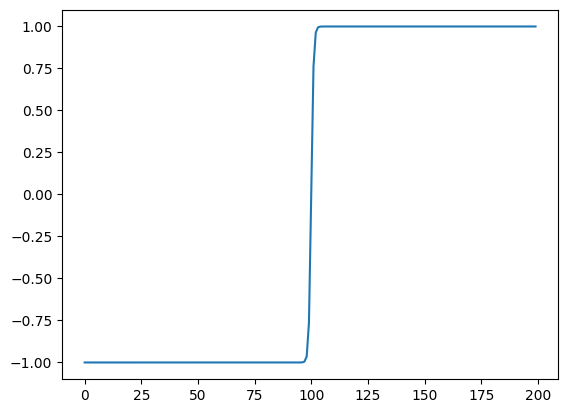

In [ ]:
torchtanh = torch.tanh(tensor_A)
plt.plot(torchtanh)

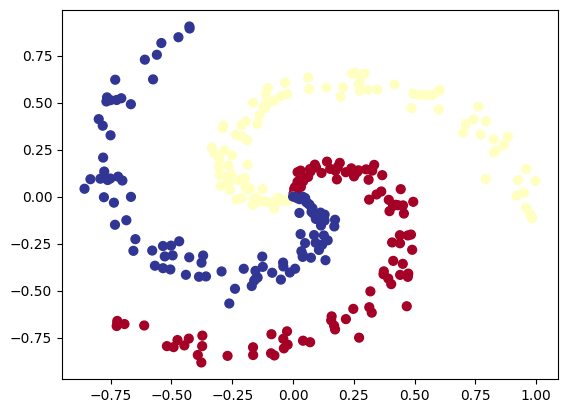

In [ ]:
#Create a multi-class dataset using the spirals data
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
def spiral_data(num_samples=100, num_classes=3, num_features=2):
    N = num_samples
    D = num_features
    K = num_classes
    X = np.zeros((N*K, D)) #300 samples will be created (300, 2)
    Y = np.zeros(N*K, dtype="uint8")
    for j in range(K):
        idx = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) #radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N) * 0.2 #theta
        X[idx] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[idx] = j
    return X, Y

X, Y = spiral_data()
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
Y = torch.from_numpy(Y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(240, 60, 240, 60)

MultiClassificationV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)
Epoch: 0 | Training Loss: 1.0918 | Training Accuracy: 35.00% | Test Loss: 1.09143, Test Accuracy: 26.67%
Epoch: 100 | Training Loss: 0.0920 | Training Accuracy: 97.50% | Test Loss: 0.06699, Test Accuracy: 100.00%
Epoch: 200 | Training Loss: 0.0364 | Training Accuracy: 99.17% | Test Loss: 0.01075, Test Accuracy: 100.00%
Epoch: 300 | Training Loss: 0.0257 | Training Accuracy: 99.17% | Test Loss: 0.00359, Test Accuracy: 100.00%
Epoch: 400 | Training Loss: 0.0212 | Training Accuracy: 99.17% | Test Loss: 0.00207, Test Accuracy: 100.00%
Epoch: 500 | Training Loss: 0.0193 | Training Accuracy: 99.17% | Test Loss: 0.00122, Test Accuracy: 100.00%
Epoch: 600 | Training Loss: 0.0174 | Training Accuracy: 99.17% | Test Loss: 0.00

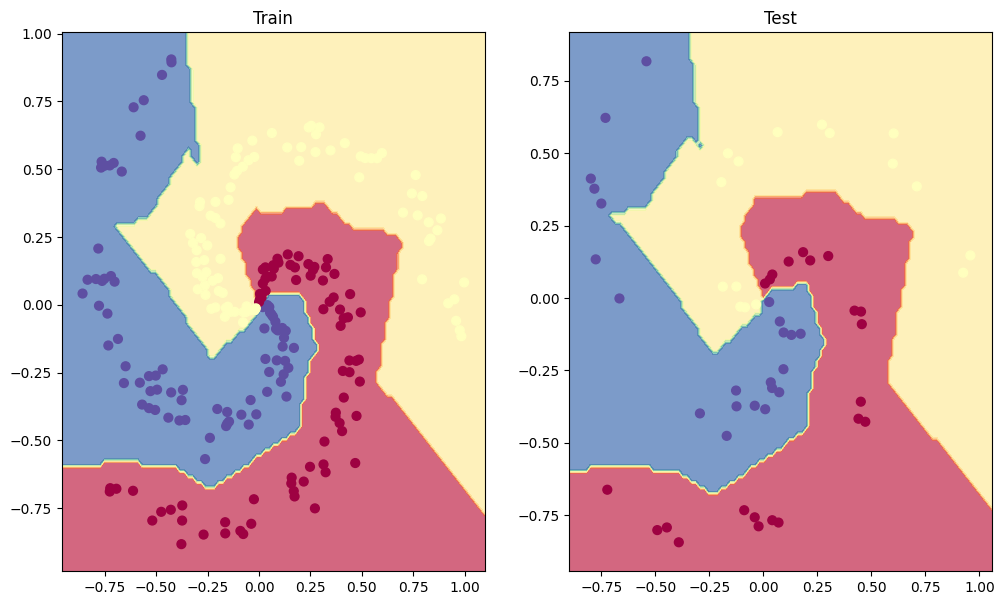

In [ ]:


class MultiClassificationV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

modelv7 = MultiClassificationV0(in_features=2, out_features=3, hidden_units=10).to(device)
print(modelv7)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=modelv7.parameters(), lr=0.02)
epochs = 1000
train_losses = []
test_losses = []
for i in range(epochs):
    modelv7.train()
    y_pred_logits = modelv7(X_train)
    y_pred_probs = torch.softmax(y_pred_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1).squeeze()
    loss = loss_fn(y_pred_logits.squeeze(), Y_train)
    acc = accuracy_fn(y_preds, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    modelv7.eval()
    with torch.inference_mode():
        y_eval_logits = modelv7(X_test)
        y_eval_probs = torch.softmax(y_eval_logits, dim=1)
        y_eval_preds = torch.argmax(y_eval_probs, dim=1).squeeze()
        eval_loss = loss_fn(y_eval_logits.squeeze(), Y_test)
        eval_acc = accuracy_fn(y_eval_preds, Y_test)

    if np.ceil(i % 100) == 0 or i==epochs-1:
        print(f"Epoch: {i} | Training Loss: {loss:.4f} | Training Accuracy: {acc:.2f}% | Test Loss: {eval_loss:.5f}, Test Accuracy: {eval_acc:.2f}%")

#inference
modelv7.eval()
with torch.inference_mode():
    y_test_logits = modelv7(X_test)
    y_test_probs = torch.softmax(y_test_logits, dim=1)
    y_test_preds = torch.argmax(y_test_probs, dim=1).squeeze()
    test_loss = loss_fn(y_test_logits.squeeze(), Y_test)
    test_acc = accuracy_fn(y_test_preds, Y_test)

#plot
def plot_decision_boundary(model, X, Y):
    X, Y = X.to("cpu"), Y.to("cpu")
    model = model.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

    model.eval()
    with torch.inference_mode():
        y_pred_logits = model(points)

    if len(torch.unique(Y)) > 2:
        y_preds = torch.softmax(y_pred_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_preds = torch.round(torch.sigmoid(y_pred_logits)) # binary

    print(xx.shape, yy.shape, y_preds.shape)
    y_preds = y_preds.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_preds, cmap=plt.cm.Spectral, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(modelv7, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelv7, X_test, Y_test)
plt.show()

### **Extra-curriculum**
- Write down 3 problems where you think machine classification could be useful (these can be anything, get creative as you like, for example, classifying credit card transactions as fraud or not fraud based on the purchase amount and purchase location features).
- Research the concept of "momentum" in gradient-based optimizers (like SGD or Adam), what does it mean?
- Spend 10-minutes reading the Wikipedia page for different activation functions, how many of these can you line up with PyTorch's activation functions?
- Research when accuracy might be a poor metric to use (hint: read "Beyond Accuracy" by by Will Koehrsen for ideas). https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/
- Watch: For an idea of what's happening within our neural networks and what they're doing to learn, watch MIT's Introduction to Deep Learning video. https://youtu.be/7sB052Pz0sQ